# "Introduction to Graph Representation Learning"
## Szkoła letnia AI-Tech 2023
### Autor: Piotr Bielak

![Logotypy sponsorów](../sponsors.png)

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://data.pyg.org/whl/torch-2.0.0+cu118.html


## 6. Zadania uczenia maszynowego na grafach

Wśród najpopularniejszych zadaniach związanych z przetwarzaniem grafów znajdziemy:

1. Klasyfikację wierzchołków
2. Predykcję krawędzi
3. Klasyfikację grafów

Zadania te można rozwiązywać w sposób:
- nadzorowany (*supervised*) - model GNNowy jest uczony bezpośrednio w zadaniu docelowym
- nienadzorowany (*unsupervised*) - model GNNowy jest uczony na innym zadaniu, a otrzymane reprezentacje są ewaluowane w zadaniu docelowym

Wykorzystamy podejście nadzorowane, czyli będziemy uczyć modele w sposób end-2-end.

## 7. Klasyfikacja wierzchołków

Zakładamy, że każdy wierzchołek w grafie może zostać skojarzony z pewną klasą – np.:
- w sieci społecznej – płeć,
- w sieci cytowań – obszar badawczy artykułu,
- w cząsteczkach chemicznych – rodzaj atomu. 

Model do klasyfikacji wierzchołków (**node classification**) będzie zbudowany z dwóch modułów: 
- sieci GNN, która na podstawie atrybutów wierzchołków oraz struktury grafu wyznaczy wektory reprezentacji wierzchołków,
- głowicy predykcyjnej, która na podstawie wektora reprezentacji wyznaczy klasę wierzchołka.

In [2]:
import torch

torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [4]:
from torch import nn
from torch.nn import functional as F


class NodeClassificationModel(nn.Module):
    
    def __init__(self, gnn: nn.Module, emb_dim: int, num_classes: int):
        super().__init__()
        
        self.gnn = gnn
        self.clf_head = nn.Linear(emb_dim, num_classes)
        
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        z = self.gnn(x=x, edge_index=edge_index)
        out = self.clf_head(z)
        
        return F.log_softmax(out, dim=-1)

Wykorzystamy zbiór Cora w celu klasyfikacji obszarów badawczych artykułów. W zbiorze został określony podział na zbiór treningowy, walidacyjny i testowy (względem wierzchołków).

In [5]:
from torch_geometric.datasets import Planetoid


dataset = Planetoid(root="/tmp/Cora/", name="Cora")
data = dataset[0]

data = data.to(device)

data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Korzystając ze standardowej pętli uczenia w PyTorchu oraz funkcji kosztu w postaci entropii krzyżowej możemy nauczyć model klasyfikacji węzłów:

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from umap import UMAP
from tqdm.auto import trange


def train(model: nn.Module, num_epochs: int):
    losses = {"train": [], "val": [], "test": []}
    f1s = {"train": [], "val": [], "test": []}
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
        weight_decay=5e-4,
    )
    
    model = model.to(device)
    
    for epoch in trange(num_epochs, desc="Epochs"):
        # Train
        model.train()
        optimizer.zero_grad()
        
        y_score = model(data.x, data.edge_index)
        loss = F.nll_loss(
            input=y_score[data.train_mask],
            target=data.y[data.train_mask],
        )
        
        loss.backward()
        optimizer.step()
        
        # Log
        model.eval()
        
        with torch.no_grad():
            y_score = model(data.x, data.edge_index).cpu()
                
        y_pred = y_score.argmax(dim=-1)
        y_true = data.y.cpu()
        
        for name, mask in (
            ("train", data.train_mask.cpu()),
            ("val", data.val_mask.cpu()),
            ("test", data.test_mask.cpu()),
        ):
            losses[name].append(
                F.nll_loss(
                    input=y_score[mask],
                    target=y_true[mask],
                )
            )
            f1s[name].append(
                f1_score(
                    y_pred=y_pred[mask],
                    y_true=y_true[mask],
                    average="macro",
                )
            )
        
    # Visualize metrics
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    axs = axs.ravel()
    axs[0].plot(range(num_epochs), losses["train"], label="Train")
    axs[0].plot(range(num_epochs), losses["val"], label="Val")
    axs[0].plot(range(num_epochs), losses["test"], label="Test")
    axs[0].set(title="Loss")
    axs[0].legend()
    
    axs[1].plot(range(num_epochs), f1s["train"], label="Train")
    axs[1].plot(range(num_epochs), f1s["val"], label="Val")
    axs[1].plot(range(num_epochs), f1s["test"], label="Test")
    best_val_f1 = max(f1s["val"])
    best_idx = f1s["val"].index(best_val_f1)
    best_test_f1 = f1s["test"][best_idx]
    
    axs[1].set(title=f"F1 (best val: {best_val_f1:.4f}, test: {best_test_f1:.4f})")
    axs[1].legend()
    
    # Visualize final embeddings
    with torch.no_grad():
        z = model.gnn(data.x, data.edge_index).cpu()
    z2d_pca = PCA(n_components=2).fit_transform(z)
    z2d_umap = UMAP(n_components=2).fit_transform(z)

    sns.scatterplot(
        x=z2d_pca[:, 0],
        y=z2d_pca[:, 1],
        hue=data.y.cpu(),
        palette="Set2",
        ax=axs[2],
    )
    axs[2].set(title="PCA")

    sns.scatterplot(
        x=z2d_umap[:, 0],
        y=z2d_umap[:, 1],
        hue=data.y.cpu(),
        palette="Set2",
        ax=axs[3],
    )
    axs[3].set(title="UMAP")


/home/pbielak/ai_tech_summer_school_graph_intro/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pbielak/ai_tech_summer_school_graph_intro/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pbielak/ai_tech_summer_sch

Nauczmy model oparty o architekturę GCN:

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

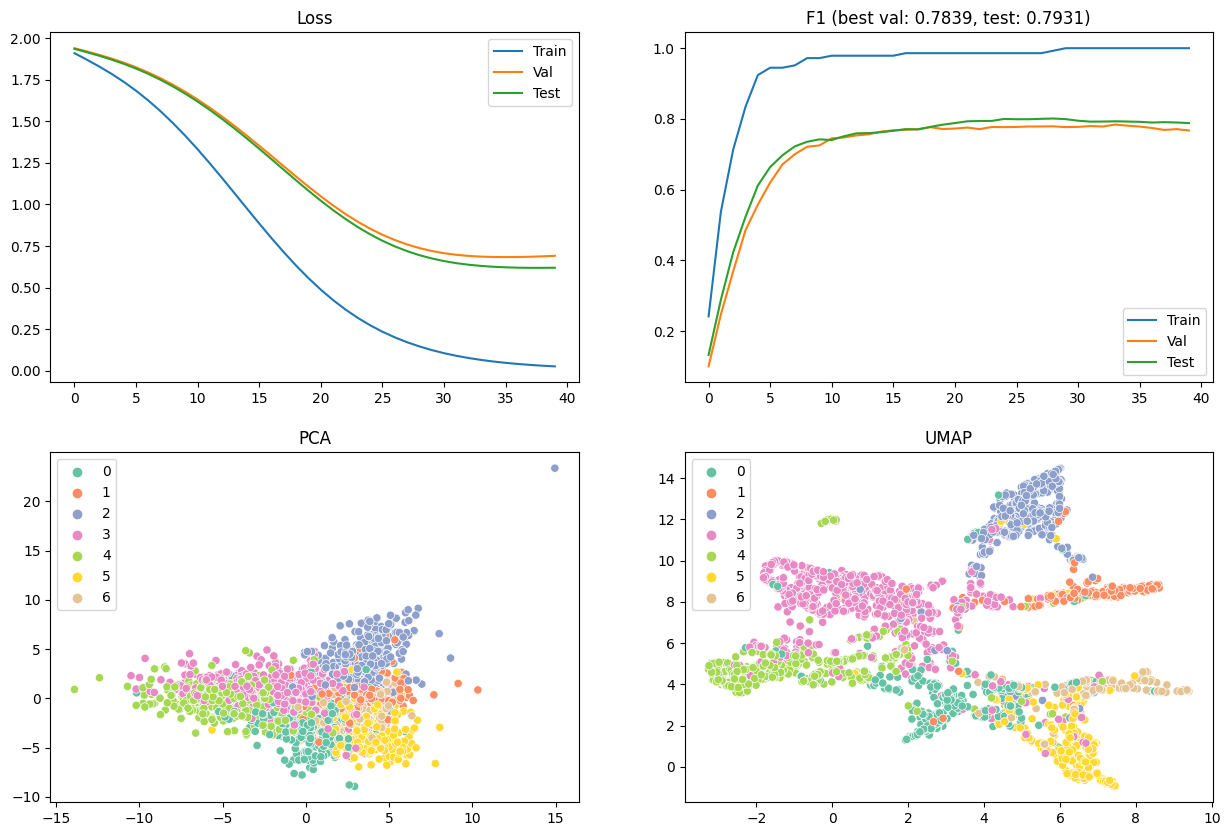

In [7]:
from torch_geometric.nn import GCN


train(
    model=NodeClassificationModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
    ),
    num_epochs=40,
)

## Zadania (10 min)

## Z.2. Sprawdzenie innych architektur

Dokonaj ewaluacji dwóch wybranych architektur GNNowych w zadaniu klasyfikacji węzłów.

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

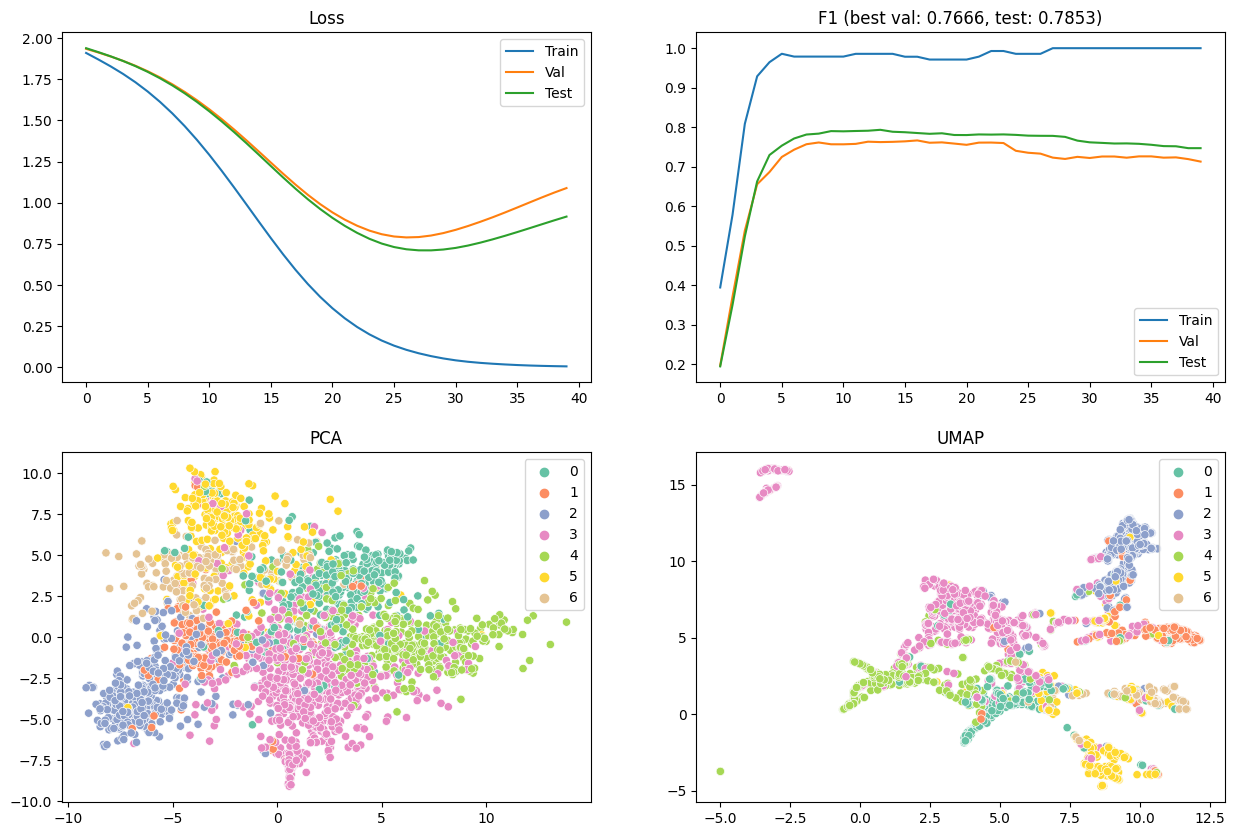

In [8]:
from torch_geometric.nn import GAT


train(
    model=NodeClassificationModel(
        gnn=GAT(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
    ),
    num_epochs=40,
)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

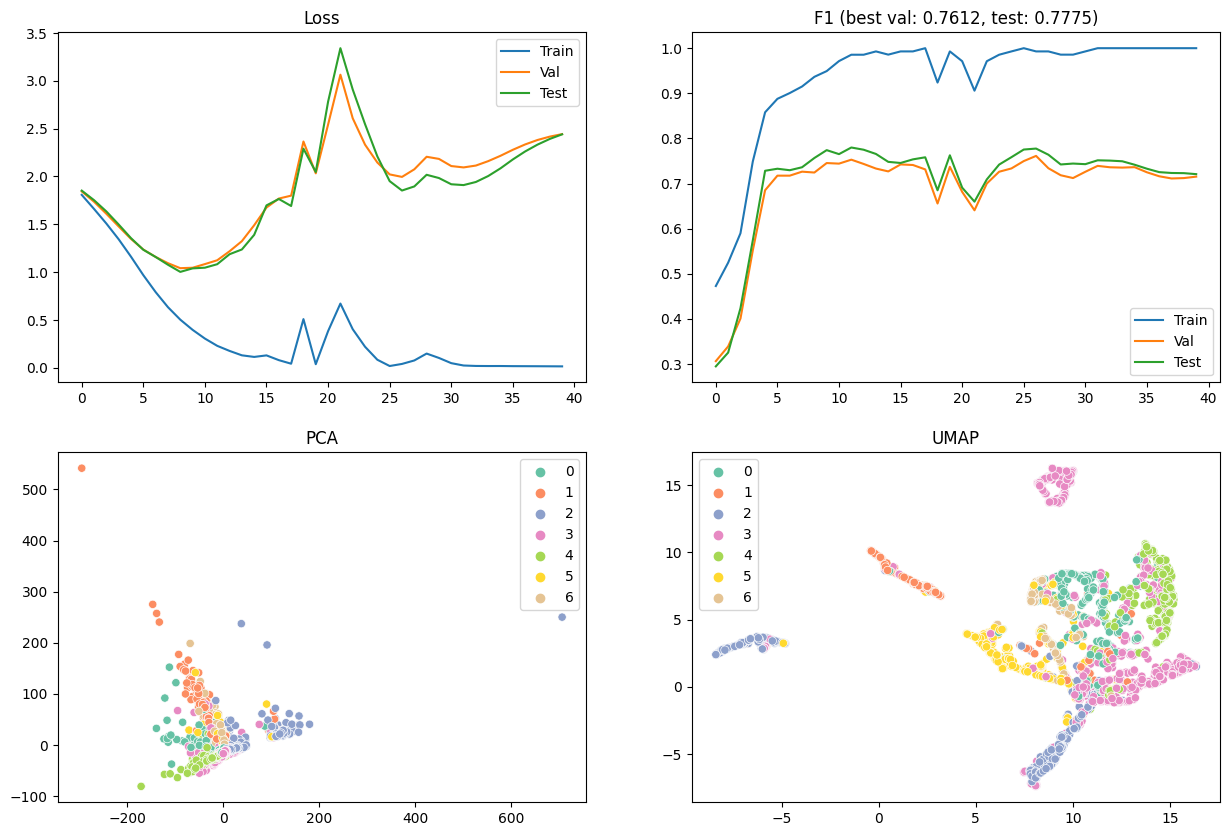

In [9]:
from torch_geometric.nn import GIN


train(
    model=NodeClassificationModel(
        gnn=GIN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
    ),
    num_epochs=40,
)